## Import Relevant Libraries and Packages

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split
from sklearn import tree

sns.set_style('whitegrid')
SEED = 2222
np.random.seed(SEED)

## Mount Google Drive to this location
Mounting Google Drive to Gooble Colaboratory allows us to access the train_jane.npz data file in the collaborative space.

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


## Load dataset available from Kaggle website

(https://www.kaggle.com/c/jane-street-market-prediction/data)

In [ ]:
%%time
train = pd.read_csv('drive/MyDrive/w207-6-spring2021-fintech/janestreet_dataset/train.csv')

CPU times: user 1min 21s, sys: 10.2 s, total: 1min 31s
Wall time: 2min 5s


## Jane Street Market Prediction - Overview 

(https://www.kaggle.com/c/jane-street-market-prediction/overview/evaluation)

This competition is evaluated on a utility score. Each row in the test set represents a trading opportunity for which you will be predicting an `action` value, 1 to make the trade and 0 to pass on it. Each trade j has an associated `weight` and `resp`, which represents a return.

For each `date` i, we define:

$$p_i = \sum_j(weight_{ij} * resp_{ij} * action_{ij}),$$
$$t = \frac{\sum p_i }{\sqrt{\sum p_i^2}} * \sqrt{\frac{250}{|i|}},$$

where $|i|$ is the number of unique dates in the test set. The utility is then defined as:

$$u = min(max(t,0), 6)  \sum p_i.$$


A first look at our dataset below shows us the variables we are working with. The `resp` variable in column 7 represent the return of a specific trade. For example, for the possible trade presented in the first line, if we had decided to do this trade, our return would have been 0.627%. 

For this final project, we are not going to use the other `resp` variables - `resp_1`, `resp_2`, `resp_3` and `resp_4` -, which represent different time horizons for the same trade (https://www.kaggle.com/pcarta/jane-street-time-horizons-and-volatilities). Since this is a rich dataset, using the `resp` variable as our reference is sufficient to run all the models proposed. 

Our utility function also uses the `weight` variable which in some sense represents the exposure of our portfolio to that specific trade. For example, in the second line below, the possible trade has a weight equal to 16.7. This means that our gain/loss would be 16.7 times the return (`resp`) if we decide to take this trade. As we can see, many trades have weight equal to zero and we will later exclude them from our dataset, since it does not add any return to our portfolio if we decide to take it. 

The dataset has 500 trading days, with 2,390,491 possible trades during these days. 82.88% of the data has weight not equal zero, leaving our dataset with 1,981,287 possible trades. Thus, it is a considerably big dataset to explore. 

For all these possible trades, there is a set of 130 features with no explanation of what the features are. This agnostic approach allows us to focus on the possible techniques we are going to use, instead of being focused on interpretability of our results. 

Finally, the `ts_id` variable in the last column of the table below shows us the enumerated trades. 



In [ ]:
display(train.head(10))
print("\nThe dataset has " + str(train['date'].nunique()) + " days.")
print("\nThe total number of trades is " + str(train['date'].count()) + ".")
print("\nThe average number of trades per day is " + str(train['date'].count()/train['date'].nunique()))

# calculate the percentage of the weight that is not zero
prcnt_nonzero_weight = (train['weight'].astype(bool).sum())*100/len(train['weight'])
print("\n" + str(round(prcnt_nonzero_weight,2)) + "% of the data has non zero weight.")

,date,weight,resp_1,resp_2,resp_3,resp_4,resp,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,...,feature_91,feature_92,feature_93,feature_94,feature_95,feature_96,feature_97,feature_98,feature_99,feature_100,feature_101,feature_102,feature_103,feature_104,feature_105,feature_106,feature_107,feature_108,feature_109,feature_110,feature_111,feature_112,feature_113,feature_114,feature_115,feature_116,feature_117,feature_118,feature_119,feature_120,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129,ts_id
0,0,0.000000,0.009916,0.014079,0.008773,0.001390,0.006270,1,-1.872746,-2.191242,-0.474163,-0.323046,0.014688,-0.002484,NaN,NaN,-0.989982,-1.055090,NaN,NaN,-2.667671,-2.001475,-1.703595,-2.196892,NaN,NaN,1.483295,1.307466,NaN,NaN,1.175200,0.967805,1.608410,1.319365,NaN,NaN,-0.515073,-0.448988,NaN,NaN,...,1.158770,NaN,3.754522,7.137163,-1.863069,NaN,0.434466,NaN,-0.292035,0.317003,-2.605820,NaN,2.896986,NaN,1.485813,4.147254,-2.238831,NaN,-0.892724,NaN,-0.156332,0.622816,-3.921523,NaN,2.561593,NaN,3.457757,6.649580,-1.472686,NaN,NaN,1.168391,8.313583,1.782433,14.018213,2.653056,12.600292,2.301488,11.445807,0
1,0,16.673515,-0.002828,-0.003226,-0.007319,-0.011114,-0.009792,-1,-1.349537,-1.704709,0.068058,0.028432,0.193794,0.138212,NaN,NaN,-0.151877,-0.384952,NaN,NaN,1.225838,0.789076,1.110580,1.102281,NaN,NaN,-0.590600,-0.625682,NaN,NaN,-0.543425,-0.547486,-0.706600,-0.667806,NaN,NaN,0.910558,0.914465,NaN,NaN,...,1.157671,NaN,1.297679,1.281956,-2.427595,NaN,0.024913,NaN,-0.413607,-0.073672,-2.434546,NaN,0.949879,NaN,0.724655,1.622137,-2.209020,NaN,-1.332492,NaN,-0.586619,-1.040491,-3.946097,NaN,0.983440,NaN,1.357907,1.612348,-1.664544,NaN,NaN,-1.178850,1.777472,-0.915458,2.831612,-1.417010,2.297459,-1.304614,1.898684,1
2,0,0.000000,0.025134,0.027607,0.033406,0.034380,0.023970,-1,0.812780,-0.256156,0.806463,0.400221,-0.614188,-0.354800,NaN,NaN,5.448261,2.668029,NaN,NaN,3.836342,2.183258,3.902698,3.045431,NaN,NaN,-1.141082,-0.979962,NaN,NaN,-1.157585,-0.966803,-1.430973,-1.103432,NaN,NaN,5.131559,4.314714,NaN,NaN,...,2.420089,NaN,0.800962,1.143663,-3.214578,NaN,1.585939,NaN,0.193996,0.953114,-2.674838,NaN,2.200085,NaN,0.537175,2.156228,-3.568648,NaN,1.193823,NaN,0.097345,0.796214,-4.090058,NaN,2.548596,NaN,0.882588,1.817895,-2.432424,NaN,NaN,6.115747,9.667908,5.542871,11.671595,7.281757,10.060014,6.638248,9.427299,2
3,0,0.000000,-0.004730,-0.003273,-0.000461,-0.000476,-0.003200,-1,1.174378,0.344640,0.066872,0.009357,-1.006373,-0.676458,NaN,NaN,4.508206,2.484260,NaN,NaN,2.902176,1.799163,3.192700,2.848359,NaN,NaN,-1.401637,-1.428248,NaN,NaN,-1.421175,-1.487976,-1.756415,-1.647543,NaN,NaN,4.766182,4.528353,NaN,NaN,...,2.330484,NaN,0.182066,1.088451,-3.527752,NaN,-1.338859,NaN,-1.257774,-1.194013,-1.719062,NaN,-0.940190,NaN,-1.510224,-1.781693,-3.373969,NaN,2.513074,NaN,0.424964,1.992887,-2.616856,NaN,0.561528,NaN,-0.994041,0.099560,-2.485993,NaN,NaN,2.838853,0.499251,3.033732,1.513488,4.397532,1.266037,3.856384,1.013469,3
4,0,0.138531,0.001252,0.002165,-0.001215,-0.006219,-0.002604,1,-3.172026,-3.093182,-0.161518,-0.128149,-0.195006,-0.143780,NaN,NaN,2.683018,1.450991,NaN,NaN,1.257761,0.632336,0.905204,0.575275,NaN,NaN,2.550883,2.484082,NaN,NaN,2.502828,2.606440,2.731251,2.566561,NaN,NaN,-1.477905,-1.722451,NaN,NaN,...,4.345282,NaN,2.737738,2.602937,-1.785502,NaN,-0.172561,NaN,-0.299516,-0.420021,-2.354611,NaN,0.762192,NaN,1.598620,0.623132,-1.742540,NaN,-0.934675,NaN,-0.373013,-1.213540,-3.677787,NaN,2.684119,NaN,2.861848,2.134804,-1.279284,NaN,NaN,0.344850,4.101145,0.614252,6.623456,0.800129,5.233243,0.362636,3.926633,4
5,0,0.000000,-0.001047,-0.002700,0.000743,0.004667,0.001282,-1


The dataset has 500 days.

The total number of trades is 2390491.

The average number of trades per day is 4780.982

82.88% of the data has non zero weight.


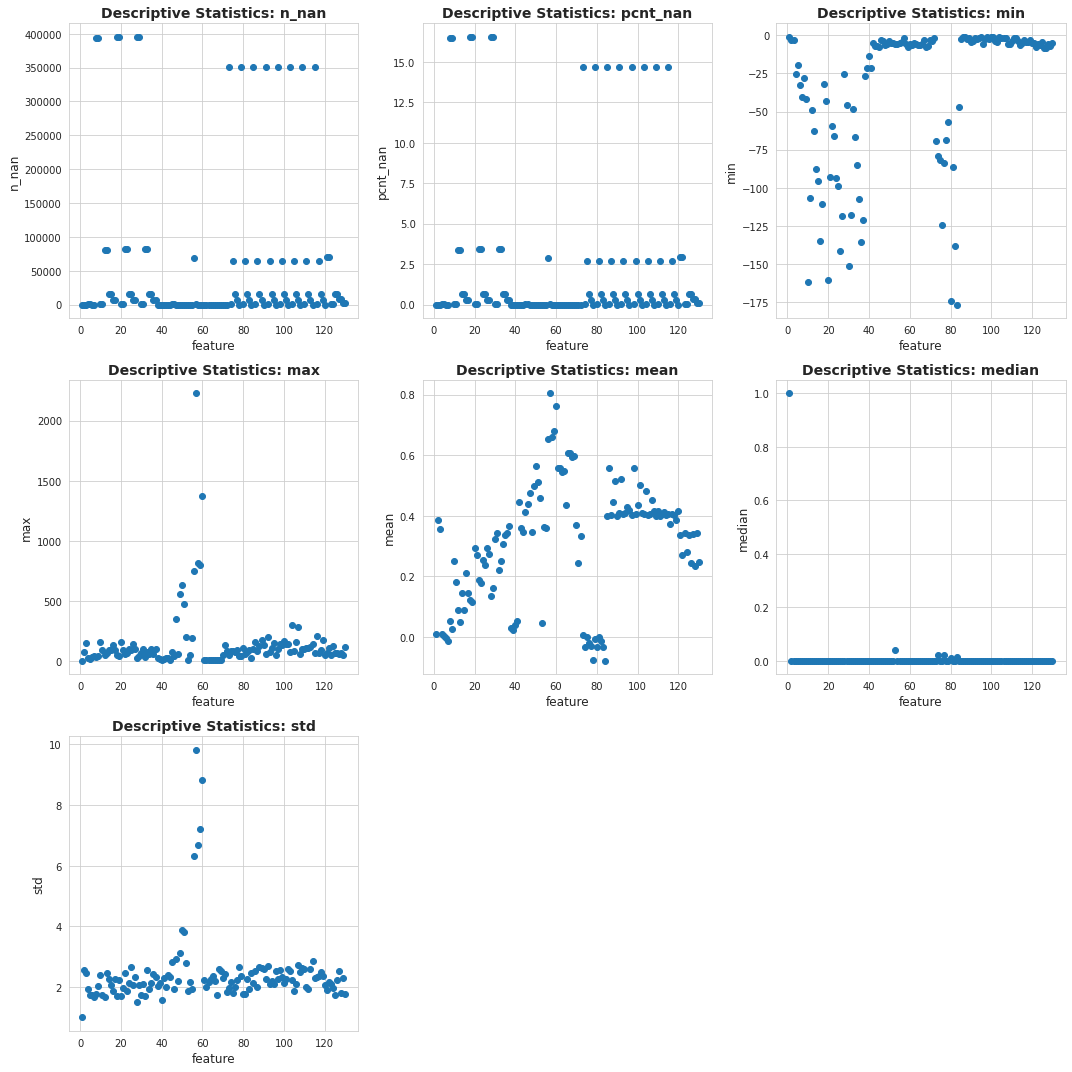

In [ ]:
# Get the number and pct of NaN per feature and other descriptive statistics
count_na={}
for col in list(train):
    if 'feature' in col:
        value = (train[col].isna()).sum()
        count_na[col]={}
        count_na[col]['n_nan']=value
        count_na[col]['pcnt_nan']=round(value*100/len(train[col]),3)
        count_na[col]['min']=train[col].min()
        count_na[col]['max']=train[col].max()
        count_na[col]['mean']=train[col].mean()
        count_na[col]['median']=train[col].median()
        count_na[col]['std']=train[col].std()

# Draw graphs for the descriptive statistics calculated above
desc_stats = ['n_nan', 'pcnt_nan', 'min', 'max', 'mean', 'median', 'std']

plt.figure(figsize=(15,15), linewidth=5)

n_plot = 1 
for stat in desc_stats:
    aux_graph = []
    for col in list(train):
        if 'feature' in col:
            aux_graph.append(count_na[col][stat])
    plt.subplot(3,3,n_plot)
    plt.scatter(range(1,131), aux_graph)
    plt.xlabel('feature', fontsize=12)
    plt.ylabel(stat, fontsize=12)
    plt.title('Descriptive Statistics: ' + stat, fontsize=14, fontweight='bold')
    plt.axis('tight')
    n_plot += 1

plt.tight_layout()
plt.show()

In [ ]:
# Drop if weights are equal to zero
train = train[train['weight'] != 0]

The graph above for the median descriptive statistics shows us that almost all features have median equal or close to zero. Thus, we will fill the NaN values using the median for all features. 

In [ ]:
# The median value is equal or close to zero for almost all features (see graph above).  
for col in list(train):
    if 'feature' in col:
        train[col] = train[col].fillna(count_na[col]['median'])
train.head(10)

,date,weight,resp_1,resp_2,resp_3,resp_4,resp,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,...,feature_91,feature_92,feature_93,feature_94,feature_95,feature_96,feature_97,feature_98,feature_99,feature_100,feature_101,feature_102,feature_103,feature_104,feature_105,feature_106,feature_107,feature_108,feature_109,feature_110,feature_111,feature_112,feature_113,feature_114,feature_115,feature_116,feature_117,feature_118,feature_119,feature_120,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129,ts_id
1,0,16.673515,-0.002828,-0.003226,-0.007319,-0.011114,-0.009792,-1,-1.349537,-1.704709,0.068058,0.028432,0.193794,0.138212,5.402186e-17,7.246478e-17,-0.151877,-0.384952,0.000002,2.515624e-17,1.225838,0.789076,1.110580,1.102281,0.0,7.772861e-17,-0.590600,-0.625682,0.0,0.0,-0.543425,-0.547486,-0.706600,-0.667806,3.716532e-17,6.746294e-17,0.910558,0.914465,0.0,0.0,...,1.157671,0.0,1.297679,1.281956,-2.427595,9.500082e-07,0.024913,0.0,-0.413607,-0.073672,-2.434546,0.0,0.949879,0.0,0.724655,1.622137,-2.209020,0.0,-1.332492,0.0,-0.586619,-1.040491,-3.946097,0.0,0.983440,0.0,1.357907,1.612348,-1.664544,0.0,0.0,-1.178850,1.777472,-0.915458,2.831612,-1.417010,2.297459,-1.304614,1.898684,1
4,0,0.138531,0.001252,0.002165,-0.001215,-0.006219,-0.002604,1,-3.172026,-3.093182,-0.161518,-0.128149,-0.195006,-0.143780,5.402186e-17,7.246478e-17,2.683018,1.450991,0.000002,2.515624e-17,1.257761,0.632336,0.905204,0.575275,0.0,7.772861e-17,2.550883,2.484082,0.0,0.0,2.502828,2.606440,2.731251,2.566561,3.716532e-17,6.746294e-17,-1.477905,-1.722451,0.0,0.0,...,4.345282,0.0,2.737738,2.602937,-1.785502,9.500082e-07,-0.172561,0.0,-0.299516,-0.420021,-2.354611,0.0,0.762192,0.0,1.598620,0.623132,-1.742540,0.0,-0.934675,0.0,-0.373013,-1.213540,-3.677787,0.0,2.684119,0.0,2.861848,2.134804,-1.279284,0.0,0.0,0.344850,4.101145,0.614252,6.623456,0.800129,5.233243,0.362636,3.926633,4
6,0,0.190575,-0.001939,-0.002301,0.001088,0.005963,0.000709,-1,-3.172026,-3.093182,-0.030588,-0.043175,0.097058,0.053483,5.402186e-17,7.246478e-17,-6.299415,-4.202503,0.000002,2.515624e-17,-3.490652,-2.675391,-3.568659,-4.095882,0.0,7.772861e-17,-3.848427,-4.144813,0.0,0.0,-3.756330,-4.310800,-4.363503,-4.510323,3.716532e-17,6.746294e-17,0.206028,0.126117,0.0,0.0,...,7.952549,0.0,3.833684,5.016898,-1.619438,9.500082e-07,-0.033943,0.0,-0.256141,-0.309591,-2.343670,0.0,1.282053,0.0,1.742529,1.223050,-1.723221,0.0,-0.076840,0.0,-0.169793,-0.364885,-3.570331,0.0,5.158737,0.0,3.648643,4.029178,-1.215047,0.0,0.0,0.336873,4.076447,0.614783,6.622176,0.800618,5.231595,0.361506,3.921714,6
7,0,3.820844,0.017395,0.021361,0.031163,0.036970,0.033473,-1,0.446050,-0.466210,0.498751,0.244116,0.412528,0.224140,5.402186e-17,7.246478e-17,0.277257,-0.458632,0.000002,2.515624e-17,2.637622,1.432136,1.374071,0.724772,0.0,7.772861e-17,-2.016985,-1.997592,0.0,0.0,-1.974451,-2.079689,-2.479893,-2.305350,3.716532e-17,6.746294e-17,1.161571,0.844683,0.0,0.0,...,0.199255,0.0,-0.121806,-0.168498,-2.408017,9.500082e-07,-1.338859,0.0,-1.257774,-1.194013,-2.647017,0.0,-0.940190,0.0,-1.510224,-1.781693,-3.313275,0.0,-1.949191,0.0,-1.085762,-2.444205,-3.511121,0.0,-1.519479,0.0,-1.468300,-1.909212,-1.978238,0.0,0.0,2.101997,4.846202,1.479875,5.261328,2.305066,4.571762,2.201537,4.429745,7
8,0,0.116557,-0.005460,-0.007301,-0.009085,-0.003546,-0.001677,1,-3.172026,-3.093182,-0.363836,-0.291496,0.128422,0.096168,5.402186e-17,7.246478e-17,-3.727364,-2.451716,0.000002,2.515624e-17,-2.825845,-2.304248,-2.534000,-3.179482,0.0,7.772861e-17,0.004298,-0.056330,0.0,0.0,-0.011601,-0.053375,-0.001363,-0.059892,3.716532e-17,6.746294e-17,-2.263565,-2.955754,0.0,0.0,...,-0.227830,0.0,-0

The graph below shows the number os trades per day in the whole sample. As we can see, it seems to be the case that the beginning of our sample presents a pattern different from the rest of the sample. Since this is a considerably big dataset, we drop off the first 85 days of our sample (threshold shown by the red line) and kept all the other days in our dataset.

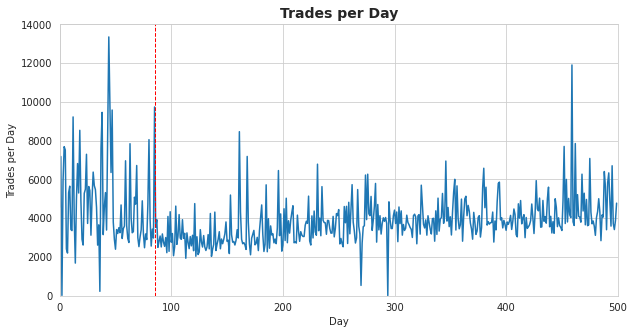

In [ ]:
trades_per_day = train.groupby(['date'])['ts_id'].count()
plt.figure(figsize=(10,5), linewidth=5)
plt.plot(trades_per_day)
plt.axvline(x=85, linestyle='--', c='red', lw=1)
plt.xlim(0,500)
plt.ylim(0)
plt.xlabel('Day')
plt.ylabel('Trades per Day')
plt.title('Trades per Day', fontsize=14, fontweight='bold')
plt.show()

In [ ]:
# Drop the first 85 days
train = train.query('date > 85').reset_index(drop = True) 

Now, let´s define our target variable. Ideally, we would like to add to our portfolio all the trades that have positive returns. In this case, we should be targeting trades where our return is bigger than zero, which means `resp > 0`. Thus, we will define our target variable, `action`, as a dummy variable that takes the value 1 when `resp > 0` and 0 otherwise. 

In [ ]:
# Define target variable
train['action'] = ((train['resp'].values) > 0).astype(int)

# Reorder the DataFrame
cols = list(train)
cols = cols[0:7] + cols[-1:] + cols[7:-1]
train = train[cols]
train.head(10)

,date,weight,resp_1,resp_2,resp_3,resp_4,resp,action,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,...,feature_91,feature_92,feature_93,feature_94,feature_95,feature_96,feature_97,feature_98,feature_99,feature_100,feature_101,feature_102,feature_103,feature_104,feature_105,feature_106,feature_107,feature_108,feature_109,feature_110,feature_111,feature_112,feature_113,feature_114,feature_115,feature_116,feature_117,feature_118,feature_119,feature_120,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129,ts_id
0,86,0.859516,-0.003656,-0.005449,-0.017403,-0.028896,-0.021435,0,1,3.151305,5.467693,-0.164505,-0.189219,0.663966,0.988896,5.402186e-17,7.246478e-17,2.184804,3.278742,0.000002,2.515624e-17,1.471544,2.391430,1.640887,3.938759,0.0,7.772861e-17,2.361346,4.711640,0.0,0.0,1.958027,4.069699,2.535238,4.813858,3.716532e-17,6.746294e-17,-0.194392,-0.336857,0.0,...,-1.515613,0.0,-1.746285,-1.086886,-3.388070,9.500082e-07,1.607253,0.0,0.199793,0.969663,-2.434601,0.0,0.227364,0.0,-0.633981,-0.122468,-4.349793,0.0,0.322244,0.0,-0.458309,-0.032740,-3.018269,0.0,-1.219454,0.0,-2.608786,-1.611309,-2.724954,0.0,0.0,2.433699,4.282284,1.621115,4.331030,2.553220,3.799011,2.642943,3.998054,527894
1,86,0.590949,0.000347,-0.000376,-0.004051,-0.007995,-0.004743,0,-1,-0.365888,0.824004,-0.293208,-0.416391,-0.599185,-0.997330,5.402186e-17,7.246478e-17,-0.869330,0.174646,0.000002,2.515624e-17,-2.376733,-2.602154,-0.580833,0.145479,0.0,7.772861e-17,-0.440224,-0.943834,0.0,0.0,-1.842764,-3.478558,-0.506549,-1.058953,3.716532e-17,6.746294e-17,0.539967,1.481719,0.0,...,0.092611,0.0,0.372403,-0.066319,-2.740989,9.500082e-07,-1.338859,0.0,-0.018706,-0.522890,-2.132602,0.0,-0.940190,0.0,1.034410,-0.590374,-2.151733,0.0,-2.471300,0.0,-0.385969,-2.290683,-3.531129,0.0,-1.673329,0.0,1.017174,-1.059342,-1.723941,0.0,0.0,-0.702873,4.038753,-0.789767,4.133183,-1.207878,3.402796,-0.928290,3.511141,527896
2,86,0.172997,0.000168,0.000333,-0.002375,-0.003064,0.001527,1,1,1.514607,0.596214,0.324062,0.154730,0.845069,0.521491,5.402186e-17,7.246478e-17,0.310387,-0.379196,0.000002,2.515624e-17,0.866451,0.148476,0.197457,-0.516572,0.0,7.772861e-17,1.025831,0.704435,0.0,0.0,1.691567,1.379021,1.111965,0.682265,3.716532e-17,6.746294e-17,-0.635982,-0.525029,0.0,...,-1.515613,0.0,-1.746285,-1.086886,-4.438488,9.500082e-07,-0.140773,0.0,-0.762597,-0.409249,-2.698973,0.0,-0.252248,0.0,-0.906413,-0.748366,-3.765935,0.0,-2.338233,0.0,-1.568599,-2.851826,-4.757620,0.0,-2.294113,0.0,-3.416992,-2.645002,-2.973197,0.0,0.0,2.304354,1.530169,3.596848,4.613493,4.516110,3.341374,2.635798,1.535235,527897
3,86,1.507813,0.001534,0.000481,-0.000082,-0.002271,-0.001663,0,-1,-1.008999,0.242132,-0.076187,-0.073584,-0.330932,-0.634109,5.402186e-17,7.246478e-17,-2.315807,-1.239785,0.000002,2.515624e-17,-1.613644,-1.536623,-1.453172,-1.752887,0.0,7.772861e-17,-0.533476,-1.390278,0.0,0.0,-2.234538,-4.535242,-0.630716,-1.602173,3.716532e-17,6.746294e-17,0.317052,1.164979,0.0,...,0.409232,0.0,0.344915,-0.001260,-2.304626,9.500082e-07,-0.445199,0.0,-0.323650,-0.270660,-1.968635,0.0,-0.441438,0.0,-0.331984,-0.531531,-2.599926,0.0,-1.285856,0.0,-0.285604,-1.189255,-2.773540,0.0,-1.145760,0.0,-0.120275,-0.893344,-1.757889,0.0,0.0,-1.700655,-0.376747,-0.876730,1.645537,-1.318172,1.369452,-1.352577,0.733124,527900
4,86,5.554003,0.003948,0.005943,0.015943,0.025001,0.017121,1,-1,-0.391784,0.152261,-0.603803,-0.711527,-1.204166,-1.579647,5.402186e-17,7.246478e-17,-1.926413,-1.156307,0.000002,2.515624e-17,-2.777077,-2.785158,-0.044156,0.595684,0.0,7.772861e-17,-0.407179,-0.649657,0.0,0.0,-2.523730,-4.040057,-0.462593,-0.696993,3.716532e-17,6.746294e-17,0.570030,1.08

In [ ]:
# Normalize the data
for col in list(train):
    if 'feature' in col:
        train[col] = (train[col]-train[col].mean())/train[col].std()
train.head()  

,date,weight,resp_1,resp_2,resp_3,resp_4,resp,action,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,...,feature_91,feature_92,feature_93,feature_94,feature_95,feature_96,feature_97,feature_98,feature_99,feature_100,feature_101,feature_102,feature_103,feature_104,feature_105,feature_106,feature_107,feature_108,feature_109,feature_110,feature_111,feature_112,feature_113,feature_114,feature_115,feature_116,feature_117,feature_118,feature_119,feature_120,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129,ts_id
0,86,0.859516,-0.003656,-0.005449,-0.017403,-0.028896,-0.021435,0,0.992237,1.057678,1.989595,-0.080238,-0.097569,0.405937,0.612344,-0.020263,-0.006269,0.826543,1.838581,-0.05248,-0.025359,0.592942,1.110270,0.777857,1.702680,-0.0623,-0.043181,1.255446,2.307346,-0.07336,-0.089809,0.825217,1.453704,1.114406,1.977000,-0.08034,-0.071868,-0.291519,-0.310806,-0.127347,...,-0.770550,-0.124455,-0.955670,-0.732540,-1.539669,-0.16417,0.408731,-0.174161,-0.116210,0.206822,-1.043211,-0.066119,-0.076444,-0.149103,-0.472588,-0.171555,-1.959118,-0.142372,-0.066641,-0.202929,-0.444366,-0.198435,-1.145281,-0.084971,-0.710075,-0.089375,-1.174055,-0.858413,-1.558422,-0.195548,-0.088966,1.014951,2.183233,0.753378,1.953918,0.877594,2.119423,1.005446,2.265791,527894
1,86,0.590949,0.000347,-0.000376,-0.004051,-0.007995,-0.004743,0,-1.007823,-0.315618,0.143251,-0.147645,-0.227670,-0.340581,-0.572987,-0.020263,-0.006269,-0.502361,-0.033930,-0.05248,-0.025359,-1.145508,-1.326769,-0.451047,-0.029473,-0.0623,-0.043181,-0.427710,-0.612713,-0.07336,-0.089809,-0.995688,-1.396218,-0.380652,-0.563485,-0.08034,-0.071868,0.144668,0.558119,-0.127347,...,-0.115289,-0.124455,0.053038,-0.194728,-1.262936,-0.16417,-0.739391,-0.174161,-0.215812,-0.452688,-0.934252,-0.066119,-0.697756,-0.149103,0.403975,-0.366978,-1.013998,-0.142372,-1.176959,-0.202929,-0.408673,-1.078472,-1.314247,-0.084971,-0.935145,-0.089375,0.347873,-0.596569,-1.033429,-0.195548,-0.088966,-0.518574,2.054129,-0.685485,1.861439,-0.639872,1.889408,-0.572383,1.979092,527896
2,86,0.172997,0.000168,0.000333,-0.002375,-0.003064,0.001527,1,0.992237,0.418626,0.052681,0.175645,0.099410,0.512968,0.333408,-0.020263,-0.006269,0.010953,-0.368029,-0.05248,-0.025359,0.319592,0.015632,-0.020551,-0.331790,-0.0623,-0.043181,0.453082,0.238328,-0.07336,-0.089809,0.697559,0.437811,0.414858,0.189738,-0.08034,-0.071868,-0.553810,-0.400715,-0.127347,...,-0.770550,-0.124455,-0.955670,-0.732540,-1.988894,-0.16417,-0.272488,-0.174161,-0.554916,-0.402474,-1.138594,-0.066119,-0.331669,-0.149103,-0.615722,-0.432964,-1.708071,-0.142372,-1.124070,-0.202929,-0.992175,-1.297179,-1.718326,-0.084971,-1.242982,-0.089375,-1.513284,-1.348781,-1.688616,-0.195548,-0.088966,0.951713,0.724233,1.932535,2.085950,1.669548,1.853751,1.002289,0.815660,527897
3,86,1.507813,0.001534,0.000481,-0.000082,-0.002271,-0.001663,0,-1.007823,-0.566723,-0.088103,-0.033982,-0.031345,-0.182044,-0.356225,-0.020263,-0.006269,-1.131747,-0.887170,-0.05248,-0.025359,-0.800784,-0.806753,-0.933566,-0.896338,-0.0623,-0.043181,-0.483736,-0.843223,-0.07336,-0.089809,-1.183382,-1.795180,-0.441681,-0.798474,-0.08034,-0.071868,0.012263,0.406779,-0.127347,...,0.013716,-0.124455,0.039950,-0.160443,-1.076319,-0.16417,-0.391125,-0.174161,-0.354822,-0.341236,-0.875094,-0.066119,-0.432346,-0.149103,-0.313921,-0.342402,-1.206711,-0.142372,-0.705794,-0.202929,-0.359154,-0.649189,-1.064652,-0.084971,-0.673531,-0.089375,-0.129549,-0.517822,-1.051234,-0.195548,-0.088966,-1.006408,-0.286695,-0.737386,0.698640,-0.684372,0.708992,-0.759840,0.343369,527900
4,86,5.554003,0.003948,0.005943,0.015943,0.025001,0.017121,1,-1.007823,-0.325730,-0.12

## Correlation / Highly Correlated Features

There are a total of 130 features (`feature_0` to `feature_129`). Are all of these features required and/or useful in terms of creating an optimal stock market prediction model?

We run through an exercise to determine if there are any features that are highly correlated to each other, and considered to be duplicates. We will evaluate if this hypothesis is correct by testing it with a fairly predictable model that has already shown to be performing well, the "Random Forest - All Features", and see what happens with the Random Forest's accuracy after the removal of the said features.



In [ ]:
# Source: https://datatable.readthedocs.io/en/latest/manual/name_mangling.html
# Initialize empty lists to store significant features and their correlation values.
corr_list = []
corr_names = []

# Get names of all columns from feature0 to feature129
filtered_train_data_names = train.columns[7:-1]

# Create a tuple of column names to compare correlations against. 
# Itertools.combinations() finds all possible combinations of 2 feature columns.
import itertools
filtered_tuple_train_data_names = list(itertools.combinations(filtered_train_data_names, 2))

#print(len(filtered_train_data_names))
#print(len(filtered_tuple_train_data_names))

# Append correlations between 2 columns into the list "corr_list"
# Source: https://datatable.readthedocs.io/en/latest/api/frame.html
# Source: https://datatable.readthedocs.io/en/latest/api/dt/corr.html
for i in range(len(filtered_tuple_train_data_names)):
    column1 = filtered_tuple_train_data_names[i][0]
    column2 = filtered_tuple_train_data_names[i][1]

    corr_list.append(train[column1].corr(train[column2]))
    corr_names.append(column1 + " & " + column2)
    

# Create a dictionary that corresponds the 2 columns & their correlation
# Source: https://www.geeksforgeeks.org/python-convert-two-lists-into-a-dictionary/
dictionary = {} 
for key in corr_names: 
    for value in corr_list: 
        dictionary[key] = value 
        corr_list.remove(value) 
        break
        
# Sort the dictionary from highest correlation to lowest correlation
# Source: https://stackoverflow.com/questions/613183/how-do-i-sort-a-dictionary-by-value
dictionary_sorted = dict(sorted(dictionary.items(), key=lambda item: item[1], reverse = True))

# Only print the key/value pairs with high positive/negative correlation. Ignore those with mild/moderate correlation.
# Source: https://stackoverflow.com/questions/11437006/filter-dict-by-certain-values
# Source: https://stackoverflow.com/questions/27537608/filter-values-of-dictionary
filtered_dict = {}
filtered_dict = {key: value for key, value in dictionary_sorted.items() if value > 0.7 or value < -0.7}
print(filtered_dict)

{'feature_67 & feature_68': 0.9988698460899346, 'feature_62 & feature_63': 0.9975006397269008, 'feature_60 & feature_61': 0.9966406839212951, 'feature_65 & feature_66': 0.9959759208268365, 'feature_89 & feature_113': 0.9922199101057192, 'feature_107 & feature_119': 0.9906073538197965, 'feature_95 & feature_119': 0.9893415394221629, 'feature_101 & feature_113': 0.9875984263182978, 'feature_122 & feature_128': 0.9832036474523899, 'feature_124 & feature_126': 0.9799644340346867, 'feature_126 & feature_128': 0.9746675045716637, 'feature_95 & feature_107': 0.9740588154326455, 'feature_89 & feature_101': 0.9724616880321938, 'feature_90 & feature_114': 0.9700472550489598, 'feature_102 & feature_114': 0.9691811180240086, 'feature_96 & feature_108': 0.9577620248017823, 'feature_19 & feature_25': 0.9560604698365921, 'feature_29 & feature_35': 0.955112885883349, 'feature_47 & feature_48': 0.9543662655474285, 'feature_84 & feature_108': 0.9532603342573499, 'feature_53 & feature_122': 0.95244059999

After analyzing this list of highly correlated values, we found that some features were highly correlated with more than 1 feature.
This finding helped us sort the features into 3 different, distinct tiers.

- Tier 1: Features that:
  - Exhibit high positive correlation (>=0.9) with 4 other features
  - Do not have a significant negative correlation (<-0.7) with any other feature
  - Features 122 128 124 126
- Tier 2: Features that:
  - Exhibit high positive correlation (>=0.9) with 2 other features
  - Do not have a significant negative correlation (<-0.7) with any other feature
  - Features 89 113 107 119 95 101 114 108 127 25 129 120 53 116 110 23
- Tier 3: Features that:
  - Exhibit high positive correlation (>=0.9) with 1 other feature
  - Do not have a significant negative correlation (<-0.7) with any other feature
  - Features 67,68,62,63,60,61,65,66,90,102,96,125,19,84,20,26,123,92,104,86,37,38,57,58,98,3,4,5,6,1,69

We then computed the Random Forest's accuracy three different ways and compared it to its baseline accuracy (51.81%):
- Removing Tier 1's features
- Removing Tier 1 and 2's features
- Removing Tier 1, 2, and 3's features







In [ ]:
# Tier 1 List: 122 128 124 126

del train['feature_122']
del train['feature_124']
del train['feature_126']
del train['feature_128']

In [ ]:
# Tier 2 List: 89 113 107 119 95 101 114 108 127 129 120 53 116 110 23

# del train['feature_89']
# del train['feature_113']
# del train['feature_107']
# del train['feature_119']
# del train['feature_95']
# del train['feature_101']
# del train['feature_114']
# del train['feature_108']
# del train['feature_129']
# del train['feature_120']
# del train['feature_53']
# del train['feature_116']
# del train['feature_110']
# del train['feature_23']

In [ ]:
# Tier 3 list: 67,68,62,63,60,61,65,66,90,102,96,125,19,84,20,26,123,92,104,86,37,38,57,58,98,3,4,5,6,1,69,24,31,32,17,18,27,28,

# del train['feature_67']
# del train['feature_68']
# del train['feature_62']
# del train['feature_63']
# del train['feature_60']
# del train['feature_61']
# del train['feature_65']
# del train['feature_66']
# del train['feature_90']
# del train['feature_102']
# del train['feature_96']
# del train['feature_125']
# del train['feature_19']
# del train['feature_84']
# del train['feature_20']
# del train['feature_26']
# del train['feature_123']
# del train['feature_92']
# del train['feature_104']
# del train['feature_86']
# del train['feature_37']
# del train['feature_38']
# del train['feature_57']
# del train['feature_58']
# del train['feature_98']
# del train['feature_3']
# del train['feature_4']
# del train['feature_5']
# del train['feature_6']
# del train['feature_1']
# del train['feature_69']
# del train['feature_24']
# del train['feature_31']
# del train['feature_32']
# del train['feature_17']
# del train['feature_18']
# del train['feature_27']
# del train['feature_28']

#### Findings:

We found that removing the Tier 1 features presented the largest boost to our Random Forest's performance.

While removing both Tier 1 and Tier 2's features presented a 0.05% accuracy boost, we felt that the significant jump in Tier 1's utility score is enough to justify the use of just removing those features without a significant loss in raw data (removal of only 4 features).

Here are the results after running the "Random Forest - All" model with the different numbers of features:
- Baseline Random Forest (130 features): 51.81% accuracy, 161.15 utility score
- Removing Tier 1's features (126 features remain): 51.97% accuracy, 301.63 utility score
- Removing Tier 1 and 2's features (112 features remain): 52.02% accuracy, 166.66 utility score
- Removing Tier 1, 2, and 3's features (74 features remain): 51.77% accuracy, 154.47 utility score

In [ ]:
# Create X_train and y_train
features = [c for c in train.columns if "feature" in c]
X_train=train[features].values
resp_cols = ['resp']
y_train = np.stack([(train['resp'] > 0).astype('int') for c in resp_cols]).T

print(X_train.shape)
print(y_train.shape)

(1571415, 126)
(1571415, 1)


## Get additional relevant variables. 



In [ ]:
dates = train['date']
weights = train['weight']
resps = train['resp']

## Save dataset in .npz format. 

This is much faster to be uploaded later and we will this dataset to run all the models. 

In [ ]:
np.savez_compressed('drive/MyDrive/w207-6-spring2021-fintech/janestreet_dataset/train_jane.npz', X_train=X_train, y_train = y_train, dates=dates, weights=weights, resps=resps)